In [163]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import matplotlib.pyplot as plt
from datetime import date,datetime


These are just a handful of methods that i had set up for quick use when processing data.

There are several more moments where i'd wish to make more of these, especially when I break the data out below, but i also wanted to handle the data by hand to practice the manipulation and the code.

In [153]:
#Useful Functions For Bird People
def Max_Value(data,column=str):
    max_value_item = data[column].value_counts().idxmax()
    max_value_quantity = data[column].value_counts().max()
    if isinstance(max_value_item, datetime):
        max_value_item = max_value_item.date()

    return max_value_item,max_value_quantity

def Min_Value(data,column=str):
    min_value_item = data[column].value_counts().idxmin()
    min_value_quantity = data[column].value_counts().min()
    if isinstance(min_value_item, datetime):
        max_value_item = min_value_item.date()
        
    return min_value_item,min_value_quantity

def Date_Fixer(data):
    data['Date'] = data['Date_time'].dt.strftime("%m-%d")
    data['Month'] = pd.to_datetime(data['Date_time']).dt.strftime('%B')
    data = data[['Month','Date','Bird Species','Location','Date_time']]
    
    return data


I downloaded the datafile from this website: https://feederwatch.org/explore/raw-dataset-requests/

The data set i used was **checklist data 2021-2024.**

When you're running this dataset, also make sure to download the **Species Translation Table** as you will need it later.

Unless you want to process the data from an absolutly fresh start, you can just start on the line that has **filtered_df**

it will pop an error if you try to access it without unzipping the file **;)**

In [ ]:
'''
#Data Import from "PFW_all_2021_2024_May2024_Public.csv"
df_new = pd.read_csv("PFW_all_2021_2024_May2024_Public.csv")
df_new
'''

In [ ]:
'''
#Filtering list down to only contain OHIO bird spots
filtered_df = df_new[df_new['SUBNATIONAL1_CODE'] == 'US-OH']
filtered_df.to_csv('Ohio_Only_Birders_DF.csv')
'''
#Data import from 'Ohio_Only_Birders_DF.csv'
filtered_df = pd.read_csv('Ohio_Only_Birders_DF.csv')
filtered_df

This process is just a lot of me checking what i have to work with, the size of the dataset at this point is about 400k rows.

In [ ]:

column_list = filtered_df.keys().tolist()
print(column_list)

filtered_df = filtered_df[['LOC_ID','LATITUDE','LONGITUDE','Month','Day','Year','SPECIES_CODE','VALID','REVIEWED']]
filtered_df

While reading through the feederwatch website, they talk about how they validate their data. Two of my columns are 'Valid' and 'Reviewed'

If Valid = 1, and Reviewed = 1 then the bird is confirmed to be the correct species
If Valid = 1, and Reviewed = 0 then the bird is the species, and did not need to be reviewed
If Valid = 0, and Reviewed = 0 then the bird species may be incorrect and needs to be reviewed
if Valid = 0, and Reviewed = 1 then the bird species is not correct and the data is not good

That was at least my interpretation, I kept all VALID values that were equal to 1

In [106]:
#Checking valid data via the websites guidelines, https://feederwatch.org/explore/raw-dataset-requests/, data appears to be only valid when VALID = 1.0 and REVIEWED = 1.0 or 0.0.  I removed all other data
#to match that format.
valid_df = filtered_df[filtered_df['VALID'] == 1.0]
valid_df

,LOC_ID,LATITUDE,LONGITUDE,Month,Day,Year,SPECIES_CODE,VALID,REVIEWED
0,L10007061,41.111452,-81.964967,1,7,2022,eursta,1.0,0.0
1,L10007061,41.111452,-81.964967,1,7,2022,dowwoo,1.0,0.0
2,L10007061,41.111452,-81.964967,1,7,2022,bkcchi,1.0,0.0
3,L10007061,41.111452,-81.964967,1,7,2022,norcar,1.0,0.0
4,L10007061,41.111452,-81.964967,1,7,2022,blujay,1.0,0.0
...,...,...,...,...,...,...,...,...,...
437417,L99248,39.079719,-84.406433,12,26,2021,moudov,1.0,0.0
437418,L99248,39.079719,-84.406433,12,26,2021,daejun,1.0,0.0
437419,L99248,39.079719,-84.406433,12,26,2021,carchi,1.0,0.0
437420,L99248,39.079719,-84.406433,12,26,2021,tuftit,1.0,0.0


I start cleaning the code here and preparing to figuring out the end game that I would like for my dataset.

First things first, I removed the 'VALID' and 'REVIEWED' columns as we've sorted them out.

The next plan is to get all the unique values for the 'SPECIES_CODE'

**There are 108 UNIQUE species on the list which is neat!**

In [109]:
#Time to start doing some cleaning, we're starting with birds here, they currently have a species code and we'll need a list of those to convert them into their actual bird names. 
#First removing the last two columns 'VALID' and 'REVIEWED' since they are no longer needed. 
valid_df = valid_df[['LOC_ID','LATITUDE','LONGITUDE','Month','Day','Year','SPECIES_CODE']]
valid_df['SPECIES_CODE'].unique().tolist()




108

We import the Species Code Translator and set up a dictionary for a quick translation.  In the next code snippet we replace all of the 'SPECIES_CODE' values with their actual Species Name, so 'eursta' becomes 'European Starling'

**European Starlings are as invasive as they are loud.**

In [ ]:
#importing the Species Code translator
species_code_df = pd.read_csv('PFW_spp_translation_table_May2024.csv')
filtered_SC_df = species_code_df[['species_code','american_english_name']]
print(filtered_SC_df)

translate_dict = filtered_SC_df.set_index('species_code')['american_english_name'].to_dict()
translate_dict



In [130]:
#replacing the SPECIES_CODE with the english bird name.
translate_dict = filtered_SC_df.set_index('species_code')['american_english_name'].to_dict()
translate_dict

valid_df['SPECIES_CODE'] = valid_df['SPECIES_CODE'].map(translate_dict)
valid_df


,LOC_ID,LATITUDE,LONGITUDE,Month,Day,Year,SPECIES_CODE
0,L10007061,41.111452,-81.964967,1,7,2022,European Starling
1,L10007061,41.111452,-81.964967,1,7,2022,Downy Woodpecker
2,L10007061,41.111452,-81.964967,1,7,2022,Black-capped Chickadee
3,L10007061,41.111452,-81.964967,1,7,2022,Northern Cardinal
4,L10007061,41.111452,-81.964967,1,7,2022,Blue Jay
...,...,...,...,...,...,...,...
437417,L99248,39.079719,-84.406433,12,26,2021,Mourning Dove
437418,L99248,39.079719,-84.406433,12,26,2021,Dark-eyed Junco
437419,L99248,39.079719,-84.406433,12,26,2021,Carolina Chickadee
437420,L99248,39.079719,-84.406433,12,26,2021,Tufted Titmouse


The commented out section below is the matches the 'LATITUDE' and 'LONGITUDE' values to actual location in Ohio.  

The method pulls the latitude and longitude data and checks using Nominatim,  which is accessible thanks to Geopy. Since you cannot rapidly pull from an API, I added a delay which when doubled with the size of the file I was converting, would cause this section to run for ~15-20 minutes.  Once the method pulls the location, it adds it back into the dataframe (it actually added two, but i just removed location_y after this point) and from there I was able to narrow the information further so that it only included **Butler County.**

!NOTE!

I went ahead and made a .csv file for the locations so that I wouldn't have to run this code snippet again, but I left in just in case someone wanted to play with it.

In [ ]:
'''
#DO NOT RUN this unless you need to reapply the locations to the coordinates, this will run for ~20 minutes before applying locations.
#for convenience I've written the df to a CSV


df_coordinates = valid_df[['LATITUDE','LONGITUDE']].drop_duplicates()
print(df_coordinates)

geolocator = Nominatim(user_agent="geoapi")

def coordinate_finder(lat,lon):
    try:
        location = geolocator.reverse((lat,lon), timeout = 10)
        return location.address if location else "UNKNOWN"
    except GeocoderTimedOut:
        return "Timeout Error"
    sleep(1)

df_coordinates['location'] = df_coordinates.apply(
    lambda row: coordinate_finder(row['LATITUDE'],row['LONGITUDE']), axis=1
)

df_coordinates = df_coordinates.merge(df_coordinates,on=['LATITUDE','LONGITUDE'], how='left')

df_coordinates_final = df_coordinates[['LATITUDE','LONGITUDE','location_x']]
df_coordinates_final.to_csv('coords_location_df.csv', sep=',',encoding='utf-8',index=False,header=True)

'''


In [103]:
## IF YOU SKIPPED THE COORDINATE FINDER METHOD, YOU START HERE.
df_coordinates_final = pd.read_csv("coords_location_df.csv")
df_coordinates_final

,LATITUDE,LONGITUDE,location_x
0,41.111452,-81.964967,"7654, Spencer Lake Road, Lafayette Township, C..."
1,41.366817,-83.659746,"58, Valleyview Drive, Bowling Green, Wood Coun..."
2,39.085438,-84.284852,"Ivy Pointe Senior Apartments, Clough Pike, Hil..."
3,40.080776,-83.026138,"279, Frontenac Place, Riverlea, Sharon Townshi..."
4,41.720257,-83.599564,"5714, Winona Drive, Ferndale, Toledo, Lucas Co..."
...,...,...,...
1206,41.061767,-80.801804,"4086, Thats Life Lane, Summer Wind, Mahoning C..."
1207,41.493492,-81.573289,"2974, Scarborough Road, Euclid Golf Historic D..."
1208,41.450140,-81.923480,"Westlake Post Office, 27300, Center Ridge Road..."
1209,41.472413,-81.865397,"1283, Bates Road, Rocky River, Cuyahoga County..."


This is finally at the end game on the data.  As mentioned above, I sorted the data to only be in **Butler County** and from there I removed any excess columns and changed the names of 'SPECIES_CODE' to 'Bird Species' and 'location_x' to 'Location' for readability.  After that we turn the 'Month','Day','Year' columns into an actual 'Date_time' column and sort all of our data by year, the way the data is set up it goes from November of the following year to April of the year.  

*ex: df_2021 is from 11-01-2020 to 4-30-2021*

This is where I start using my methods since I wanted to do a section for each year.


In [ ]:
merged_loc_df = pd.merge(valid_df,df_coordinates_final,on=['LATITUDE','LONGITUDE'],how='left')
butler_county_df = merged_loc_df[merged_loc_df['location_x'].str.contains('Butler County')]
final_df = butler_county_df.rename(columns={'SPECIES_CODE': 'Bird Species','location_x' : 'Location'})
final_df['Date_time'] = pd.to_datetime(final_df[['Month','Day','Year']])

#df_YEAR would be from 11-202x to 4-202y
df_2021_temp = final_df[(final_df['Date_time'] >= '2020-11-01') & (final_df['Date_time'] <= '2021-04-30')]
df_2022_temp = final_df[(final_df['Date_time'] >= '2021-11-01') & (final_df['Date_time'] <= '2022-04-30')]
df_2023_temp = final_df[(final_df['Date_time'] >= '2022-11-01') & (final_df['Date_time'] <= '2023-04-30')]
df_2024_temp = final_df[(final_df['Date_time'] >= '2023-11-01') & (final_df['Date_time'] <= '2024-04-30')]
Nuthatch_df_temp = final_df[(final_df['Bird Species'].str.contains('White-breasted Nuthatch'))]
print(Nuthatch_df_temp.size)
df_2021 = Date_Fixer(df_2021_temp)
df_2022 = Date_Fixer(df_2022_temp)
df_2023 = Date_Fixer(df_2023_temp)
df_2024 = Date_Fixer(df_2024_temp)
Nuthatch_df = Date_Fixer(Nuthatch_df_temp)

print(Nuthatch_df.size)




# Fun Bird Stats for 2021
- In 2021, we saw a variety of birds, 52 varieties to be exact!
- The most common bird is the Northern Cardinal with 210 sightings!
- The least seen bird is the Ruby-throated Hummingbird with 1 sightings!
- The busiest location is 6963, Imhoff Road, Reily Township, Butler County, Ohio, 45056, United States with 439 visits!
- The busiest day is 11-30 with 81 visits!

In [ ]:
#2021 Stats
print(df_2021.shape)
print('- In 2021, we saw a variety of birds, ' + str(len(list(df_2021['Bird Species'].unique()))) + ' varieties to be exact!')

#Top Bird
top_bird_df_2021,top_bird_count_2021 = Max_Value(df_2021,'Bird Species')
print(f'- The most common bird is the {top_bird_df_2021} with {top_bird_count_2021} sightings!')

#Rare Bird
rare_bird_df_2021,rare_bird_count_2021 = Min_Value(df_2021,'Bird Species')
print(f'- The least common bird is the {rare_bird_df_2021} with {rare_bird_count_2021} sightings!')

#Busiest Location
busiest_location_df_2021,location_visits_df_2021 = Max_Value(df_2021,'Location')
print(f'- The busiest location is {busiest_location_df_2021} with {location_visits_df_2021} visits!')

#Busiest Day
busiest_day_df_2021, day_visits_df_2021 = Max_Value(df_2021,'Date')
print(f'- The busiest day is {busiest_day_df_2021} with {day_visits_df_2021} visits!')

# Fun Bird Stats For 2022
- In 2022, we saw a variety of birds, 59 varieties to be exact!
- The most common bird is the Northern Cardinal with 214 sightings!
- The least common bird is the Yellow-bellied Sapsucker with 1 sightings!
- The busiest location is 7061, Forest View Drive, West Chester Township, Butler County, Ohio, 45069, United States with 555 visits!
- The busiest day is 03-12 with 96 visits!

In [ ]:
#2022 Stats

print(df_2022.shape)
print('- In 2022, we saw a variety of birds, ' + str(len(list(df_2022['Bird Species'].unique()))) + ' varieties to be exact!')

#Top Bird
top_bird_df_2022,top_bird_count_2022 = Max_Value(df_2022,'Bird Species')
print(f'- The most common bird is the {top_bird_df_2022} with {top_bird_count_2022} sightings!')

#Rare Bird
rare_bird_df_2022,rare_bird_count_2022 = Min_Value(df_2022,'Bird Species')
print(f'- The least common bird is the {rare_bird_df_2022} with {rare_bird_count_2022} sightings!')

#Busiest Location
busiest_location_df_2022,location_visits_df_2022 = Max_Value(df_2022,'Location')
print(f'- The busiest location is {busiest_location_df_2022} with {location_visits_df_2022} visits!')

#Busiest Day
busiest_day_df_2022, day_visits_df_2022 = Max_Value(df_2022,'Date')
print(f'- The busiest day is {busiest_day_df_2022} with {day_visits_df_2022} visits!')


# Fun Bird Stats For 2023
- In 2023, we saw a variety of birds, 57 varieties to be exact!
- The most common bird is the Northern Cardinal with 188 sightings!
- The least common bird is the Evening Grosbeak with 1 sightings!
- The busiest location is 7061, Forest View Drive, West Chester Township, Butler County, Ohio, 45069, United States with 626 visits!
- The busiest day is 03-25 with 108 visits!


In [ ]:
#2023 Stats
print(df_2023.shape)
print('- In 2023, we saw a variety of birds, ' + str(len(list(df_2023['Bird Species'].unique()))) + ' varieties to be exact!')

#Top Bird
top_bird_df_2023,top_bird_count_2023 = Max_Value(df_2023,'Bird Species')
print(f'- The most common bird is the {top_bird_df_2023} with {top_bird_count_2023} sightings!')

#Rare Bird
rare_bird_df_2023,rare_bird_count_2023 = Min_Value(df_2023,'Bird Species')
print(f'- The least common bird is the {rare_bird_df_2023} with {rare_bird_count_2023} sightings!')

#Busiest Location
busiest_location_df_2023,location_visits_df_2023 = Max_Value(df_2023,'Location')
print(f'- The busiest location is {busiest_location_df_2023} with {location_visits_df_2023} visits!')

#Busiest Day
busiest_day_df_2023, day_visits_df_2023 = Max_Value(df_2023,'Date')
print(f'- The busiest day is {busiest_day_df_2023} with {day_visits_df_2023} visits!')


# Fun Bird Stats For 2024
- In 2024, we saw a variety of birds, 61 varieties to be exact!
- The most common bird is the House Finch with 229 sightings!
- The least common bird is the Evening Grosbeak with 1 sightings!
- The busiest location is Oxford Millville Road, Oxford, Hanover Township, Butler County, Ohio, 45056, United States with 609 visits!
- The busiest day is 02-03 with 131 visits!

In [ ]:
#2024 Stats
print(df_2024.shape)
print('- In 2024, we saw a variety of birds, ' + str(len(list(df_2024['Bird Species'].unique()))) + ' varieties to be exact!')

#Top Bird
top_bird_df_2024,top_bird_count_2024 = Max_Value(df_2024,'Bird Species')
print(f'- The most common bird is the {top_bird_df_2024} with {top_bird_count_2024} sightings!')

#Rare Bird
rare_bird_df_2024,rare_bird_count_2024 = Min_Value(df_2024,'Bird Species')
print(f'- The least common bird is the {rare_bird_df_2024} with {rare_bird_count_2024} sightings!')

#Busiest Location
busiest_location_df_2024,location_visits_df_2024 = Max_Value(df_2024,'Location')
print(f'- The busiest location is {busiest_location_df_2024} with {location_visits_df_2024} visits!')

#Busiest Day
busiest_day_df_2024, day_visits_df_2024 = Max_Value(df_2024,'Date')
print(f'- The busiest day is {busiest_day_df_2024} with {day_visits_df_2024} visits!')




Below is a lot of data sorting before I move onto plotting data.

For the project currently, I only used **feeder_visits** and **Nuthatch_df**

I did add some prints for some fun information: top 5 birds, top 5 locations 

In [ ]:
birds_of_2021 = df_2021.groupby('Bird Species').size().reset_index(name='Count').sort_values(by='Count',ascending=False)
Locations_of_2021 = df_2021.groupby('Location').size().reset_index(name='Count').sort_values(by='Count',ascending=False)
feeder_visits = df_2021.groupby('Month').size().reset_index(name='Count 2021').sort_values(by='Month',ascending=False)
print(birds_of_2021.head(5))
print(Locations_of_2021.head(5))
feeder_visits

In [ ]:
birds_of_2022 = df_2022.groupby('Bird Species').size().reset_index(name='Count').sort_values(by='Count',ascending=False)
Locations_of_2022 = df_2022.groupby('Location').size().reset_index(name='Count').sort_values(by='Count',ascending=False)
df_2022_counts = df_2022.groupby('Month').size().reset_index(name='Count 2022')
feeder_visits = pd.merge(feeder_visits,df_2022_counts, on='Month', how='outer')
print(birds_of_2022.head(5))
print(Locations_of_2022.head(5))
print(feeder_visits)

In [ ]:
birds_of_2023 = df_2023.groupby('Bird Species').size().reset_index(name='Count').sort_values(by='Count',ascending=False)
Locations_of_2023 = df_2023.groupby('Location').size().reset_index(name='Count').sort_values(by='Count',ascending=False)
df_2023_counts = df_2023.groupby('Month').size().reset_index(name='Count 2023')
feeder_visits = pd.merge(feeder_visits,df_2023_counts, on='Month',how='outer')
print(birds_of_2023.head(5))
print(Locations_of_2023.head(5))

In [ ]:
birds_of_2024 = df_2024.groupby('Bird Species').size().reset_index(name='Count').sort_values(by='Count',ascending=False)
Locations_of_2024 = df_2024.groupby('Location').size().reset_index(name='Count').sort_values(by='Count',ascending=False)
df_2024_counts = df_2024.groupby('Month').size().reset_index(name='Count 2024')
feeder_visits = pd.merge(feeder_visits,df_2024_counts,on='Month',how='outer')
print(birds_of_2024.head(5))
print(Locations_of_2024.head(5))
print(feeder_visits.columns)

This is a plot just for number of feeder visits per Month!

To be honest, I found this information to be much less interesting than I expected.

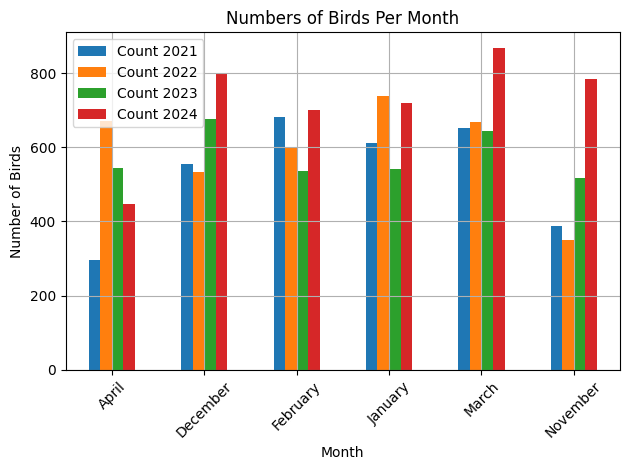

In [219]:
### PLOTS ###
#  matplotlib is plt
ax = feeder_visits.plot(kind='bar')

ax.set_title('Monthly bird visits')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Birds')

plt.xticks(rotation=45)

plt.tight_layout()
plt.grid()
plt.xlabel('Month')
plt.ylabel('Number of Birds')
plt.title('Numbers of Birds Per Month')
plt.legend()

plt.show()

### Congratulations if you've made it this far, now we'll talk about my favorite bird!

The graphs are for the nuthatches most active months, January and December, added together over the years for a look at what days Nuthatch's prefer to visit their local feeders.   I had noticed in the Nuthatch Locations that they were constantly showing up at the Imhoff Rd. Feeder so that means I could have a good chance of going and seeing in this coming year on 12/27/24 or 1/10/25!

I will have to update if my local Nuthatch shows up on my feeders during that time.

If you're still itching for more White-Breasted Nuthatch information, [Click Here](https://www.allaboutbirds.org/guide/White-breasted_Nuthatch/overview)

In [ ]:
print(Nuthatch_df.size)

Nuthatch_Monthly_df = Nuthatch_df.groupby('Month').size().reset_index(name='Count').sort_values(by='Count',ascending=False)
Nuthatch_Locations_df = Nuthatch_df.groupby('Location').size().reset_index(name='Count').sort_values(by='Count',ascending=False)
Nuthatch_January_df = Nuthatch_df[(Nuthatch_df['Month'] == 'January')]
Nuthatch_January_Days_df = Nuthatch_January_df.groupby('Date').size().reset_index(name='Count')
Nuthatch_December_df = Nuthatch_df[(Nuthatch_df['Month'] == 'December')]
Nuthatch_December_Days_df = Nuthatch_December_df.groupby('Date').size().reset_index(name='Count')
print(Nuthatch_Monthly_df.head(5))
print(Nuthatch_Locations_df.head(5))
print(Nuthatch_December_Days_df.head(5))
print(Nuthatch_January_Days_df.head(5))

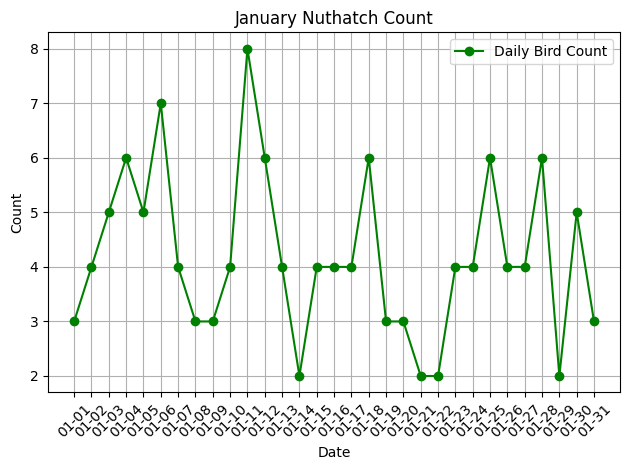

In [197]:
#NUTHATCH January CHART
plt.plot(Nuthatch_January_Days_df['Date'],Nuthatch_January_Days_df['Count'],marker='o',color='green',label='Daily Bird Count')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('January Nuthatch Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()



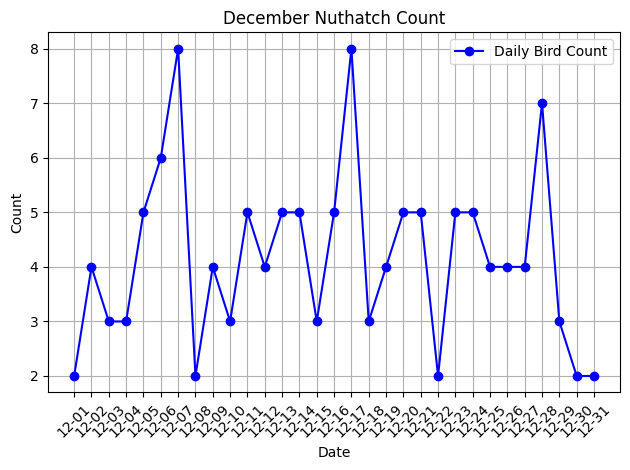

In [199]:
#NUTHATCH December CHART
plt.plot(Nuthatch_December_Days_df['Date'],Nuthatch_December_Days_df['Count'],marker='o',color='blue',label='Daily Bird Count')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('December Nuthatch Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()